In [7]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import random

WEEKDAYS = {wd.weekday(): wd.day_name() for wd in pd.Series([f'2020-6-{i+1}' for i in range(7)], dtype='datetime64[ns]')}
MONTHS = {mon.month: mon.month_name() for mon in pd.Series([f'2020-{i+1}-1' for i in range(12)], dtype='datetime64[ns]')}

In [8]:
segment_directory = "data/segmentation.csv"

segment = pd.read_csv(segment_directory, header=0 )

In [9]:
segment['Recency'] = pd.to_datetime(segment['Recency'],format='%Y-%m-%d')
segment['weekday'] = segment['Recency'].dt.weekday
segment['month'] = segment['Recency'].dt.month

min_date = segment['Recency'].min()
segment['day'] = segment['Recency'].apply(lambda x: pd.to_timedelta(x - min_date, unit='d')).dt.days

segment['MonetaryLog'] = np.log(segment['Monetary'].to_numpy()+1)
segment['FrequencyLog'] = np.log2(segment['Frequency'].to_numpy()+1)
segment['AverageMonetary'] = segment['Monetary'] / segment['Frequency']
segment['AverageMonetaryLog'] = np.log2(segment['AverageMonetary'].to_numpy()+1)

segment.columns

Index(['CustomerId', 'Monetary', 'Recency', 'Frequency', 'factor_1',
       'factor_2', 'factor_3', 'factor_4', 'weekday', 'month', 'day',
       'MonetaryLog', 'FrequencyLog', 'AverageMonetary', 'AverageMonetaryLog'],
      dtype='object')

In [10]:
display(segment.describe())
segment.head()

,Monetary,Frequency,factor_1,factor_2,factor_3,factor_4,weekday,month,day,MonetaryLog,FrequencyLog,AverageMonetary,AverageMonetaryLog
count,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000
mean,129.972264,3.950687,0.500008,0.497864,0.495451,0.498427,3.568375,4.118313,107.117312,4.096670,1.926781,36.570692,4.596182
std,179.809263,5.189864,0.290144,0.291103,0.289034,0.288478,1.935700,1.724022,51.236764,1.311051,0.939083,53.285177,1.266404
min,0.000000,1.000000,0.000000,0.000000,0.000037,0.000033,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,20.910000,1.000000,0.250000,0.240000,0.242545,0.248739,2.000000,3.000000,73.000000,3.086943,1.000000,13.415000,3.849499
50%,59.275000,2.000000,0.500000,0.500000,0.496410,0.498833,4.000000,4.000000,116.000000,4.098917,1.584963,21.250000,4.475733
75%,170.000000,5.000000,0.750000,0.750000,0.744476,0.747424,5.000000,6.000000,158.000000,5.141664,2.584963,42.500000,5.442943
max,3040.000000,111.000000,1.000000,1.000000,0.999996,0.999943,6.000000,6.000000,166.000000,8.019942,6.807355,504.000000,8.980140


,CustomerId,Monetary,Recency,Frequency,factor_1,factor_2,factor_3,factor_4,weekday,month,day,MonetaryLog,FrequencyLog,AverageMonetary,AverageMonetaryLog
0,8b4f8c66-7589-4734-8ada-2d42f60540ab,100.40,2019-06-04,6,0.35,0.08,0.609740,0.949383,1,6,154,4.619073,2.807355,16.733333,4.148392
1,2151b2a2-8867-4986-9e00-449c2b4f89e9,170.00,2019-05-25,4,0.66,0.16,0.942272,0.479846,5,5,144,5.141664,2.321928,42.500000,5.442943
2,3111db79-6721-4ec0-82b1-30b810649c5e,70.75,2019-05-25,6,0.92,0.20,0.323030,0.007076,5,5,144,4.273188,2.807355,11.791667,3.677132
3,9cb76426-cc5d-4fa3-88bc-b92314b9f4e8,75.00,2019-03-20,10,0.35,0.78,0.876833,0.088974,2,3,78,4.330733,3.459432,7.500000,3.087463
4,5d86caeb-2d53-44a7-b379-7f15f06ca821,94.51,2019-04-10,5,0.51,0.44,0.912099,0.206194,2,4,99,4.559231,2.584963,18.902000,4.314842


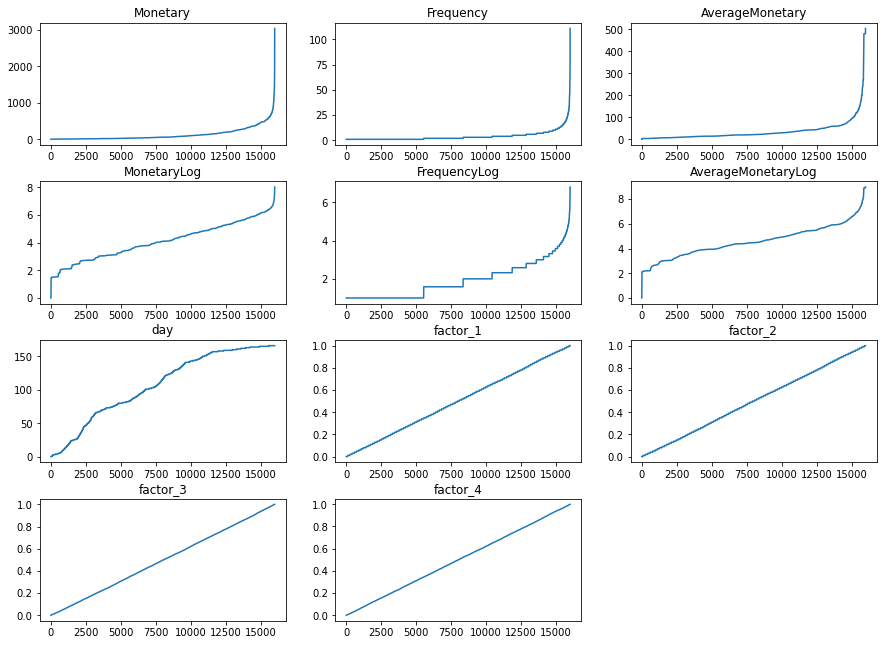

In [11]:
plt.figure(figsize=(15, 11))
plt.subplots_adjust(hspace=0.3)
for index, factor in enumerate(['Monetary', 'Frequency', 'AverageMonetary', 
                                'MonetaryLog', 'FrequencyLog', 'AverageMonetaryLog', 
                                'day', 'factor_1', 'factor_2', 'factor_3', 'factor_4', ]):
    ax = plt.subplot(4, 3, index+1)
    plt.plot(segment[factor].sort_values().reset_index()[factor])
    ax.set_title(factor)

<AxesSubplot:xlabel='factor_3'>

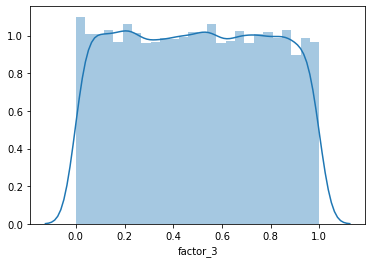

In [11]:
sns.distplot(segment["factor_3"])

In [12]:
from sklearn.feature_selection import chi2
from scipy.stats import uniform

segment['factor_5'] = uniform(0, 1).rvs(size=16000)
segment[['MonetaryLog', 'FrequencyLog', 'AverageMonetaryLog', 'day', 'month', 'factor_1', 'factor_2', 'factor_3', 'factor_4', 'factor_5']].corr()

,MonetaryLog,FrequencyLog,AverageMonetaryLog,day,month,factor_1,factor_2,factor_3,factor_4,factor_5
MonetaryLog,1.000000,0.727698,0.763319,0.317643,0.316494,-0.007026,0.004844,-0.011029,-0.000627,-0.002068
FrequencyLog,0.727698,1.000000,0.117143,0.340546,0.335052,-0.000594,0.006027,0.002593,-0.002809,-0.003716
AverageMonetaryLog,0.763319,0.117143,1.000000,0.132789,0.136954,-0.010031,0.000044,-0.017847,0.001800,0.000368
day,0.317643,0.340546,0.132789,1.000000,0.989336,-0.002042,0.008931,-0.012122,0.001852,-0.014784
month,0.316494,0.335052,0.136954,0.989336,1.000000,-0.003005,0.007675,-0.011409,0.003832,-0.015106
factor_1,-0.007026,-0.000594,-0.010031,-0.002042,-0.003005,1.000000,-0.005630,-0.000411,-0.011337,-0.005515
factor_2,0.004844,0.006027,0.000044,0.008931,0.007675,-0.005630,1.000000,0.006977,0.011048,0.004755
factor_3,-0.011029,0.002593,-0.017847,-0.012122,-0.011409,-0.000411,0.006977,1.000000,-0.003524,0.008257
factor_4,-0.000627,-0.002809,0.001800,0.001852,0.003832,-0.011337,0.011048,-0.003524,1.000000,0.005866
factor_5,-0.002068,-0.003716,0.000368,-0.014784,-0.015106,-0.005515,0.004755,0.008257,0.005866,1.000000



# Все factor_* имеют равномерное распределение
# Ни один из factor_* не коррелирует с другими факторами
# Все factor_* бесполезны и не несут полезной информации для сегментации пользователей 

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

numeric_features = [
    'day',
    'MonetaryLog', 
    'FrequencyLog', 
    'AverageMonetaryLog', 
]

categorical_features = [
    'weekday', 
    'month',
]

df = segment[numeric_features+categorical_features]

preprocessor = ColumnTransformer([
    ('nums', MinMaxScaler(), numeric_features),
    ('cats', OneHotEncoder(categories='auto'), categorical_features)
])

df_preproc = preprocessor.fit_transform(df)
cats = preprocessor.named_transformers_['cats'].get_feature_names(categorical_features)
features = numeric_features + list(cats)
df_scaled = pd.DataFrame(df_preproc, columns=features)
df_scaled.describe()

,day,MonetaryLog,FrequencyLog,AverageMonetaryLog,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_1,month_2,month_3,month_4,month_5,month_6
count,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.00000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.00000,16000.000000,16000.000000
mean,0.645285,0.510810,0.159587,0.511816,0.104500,0.094375,0.103375,0.08500,0.227437,0.209375,0.175937,0.124813,0.057188,0.199437,0.12600,0.178563,0.314000
std,0.308655,0.163474,0.161706,0.141023,0.305918,0.292359,0.304458,0.27889,0.419190,0.406875,0.380779,0.330517,0.232208,0.399590,0.33186,0.382998,0.464131
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.439759,0.384908,0.000000,0.428668,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.698795,0.511091,0.100728,0.498404,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,0.951807,0.641110,0.272923,0.606109,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


c:\ananas79\programs\python64\lib\site-packages\ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
c:\ananas79\programs\python64\lib\site-packages\ipykernel_launcher.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0.5, 0, '')

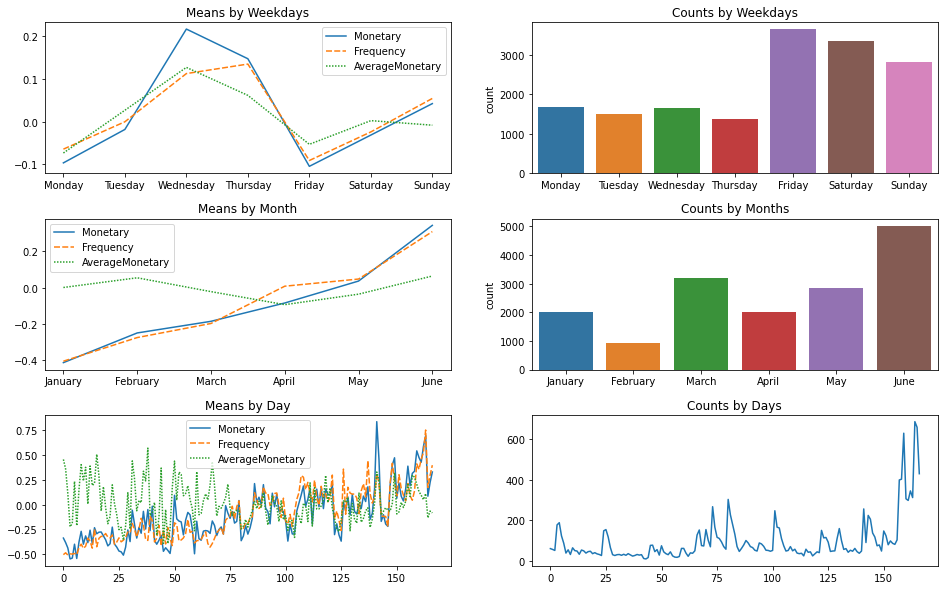

In [14]:
from sklearn.preprocessing import StandardScaler

columns = ['Monetary', 'Frequency', 'AverageMonetary',]

_df_data = pd.DataFrame(StandardScaler().fit_transform(segment[columns]), columns=columns)
_df_data['weekday'] = df['weekday']
_df_data['month'] = df['month']
_df_data['day'] = df['day']

plt.figure(figsize=(16, 10))

plt.subplot(3, 2, 1)
plt.subplots_adjust(hspace=0.3)
mean_wd = _df_data.groupby('weekday').mean()
ax = sns.lineplot(data=mean_wd[columns])
ax.set_title('Means by Weekdays')
ax.set_xlabel(None)
ax.set_xticklabels([0]+list(WEEKDAYS.values()))

plt.subplot(3, 2, 2)
count_wd = _df_data['weekday'].value_counts().sort_index().rename('count')
ax = sns.barplot(x=count_wd.index, y=count_wd)
ax.set_title('Counts by Weekdays')
ax.set_xlabel(None)
ax.set_xticklabels(list(WEEKDAYS.values()))


plt.subplot(3, 2, 3)
mean_mth = _df_data.groupby('month').mean()
ax = sns.lineplot(data=mean_mth[columns])
ax.set_xticklabels([0]+list(MONTHS.values()))
ax.set_title('Means by Month')
ax.set_xlabel(None)

plt.subplot(3, 2, 4)
count_mnt = _df_data['month'].value_counts().sort_index().rename('count')
ax = sns.barplot(x=count_mnt.index, y=count_mnt)
ax.set_title('Counts by Months')
ax.set_xlabel(None)
ax.set_xticklabels(list(MONTHS.values())[:6])


plt.subplot(3, 2, 5)
mean_day = _df_data.groupby('day').mean()
ax = sns.lineplot(data=mean_day[columns])
ax.set_title('Means by Day')
ax.set_xlabel(None)

plt.subplot(3, 2, 6)
count_day = _df_data['day'].value_counts().sort_index().rename('count')
ax = sns.lineplot(data=count_day)
ax.set_title('Counts by Days')
ax.set_xlabel(None)

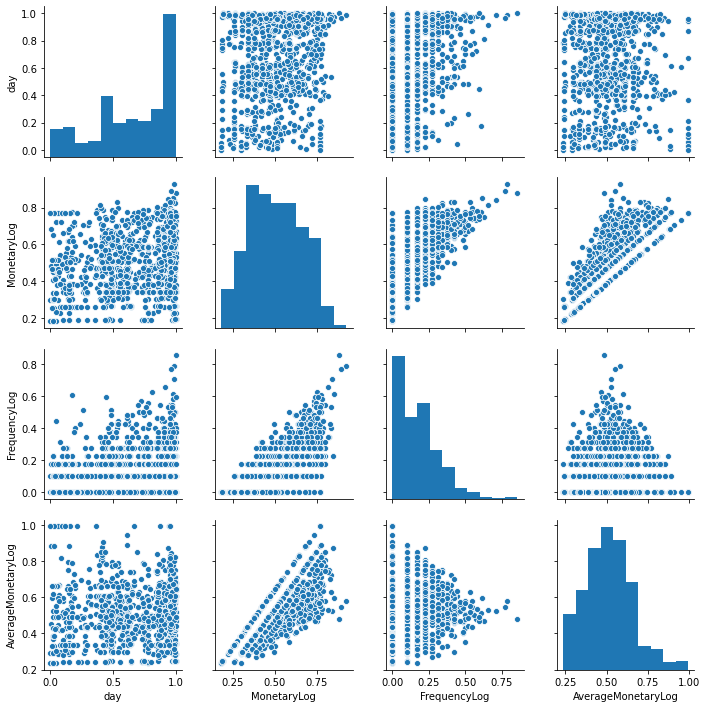

In [15]:
sns.pairplot(df_scaled[numeric_features].sample(1000))

In [16]:
random_state = 999
pca = PCA(n_components=2, random_state=random_state)
pca_result = pca.fit_transform(df_scaled[features])

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.18625906 0.12219669]


<AxesSubplot:xlabel='pca0', ylabel='pca1'>

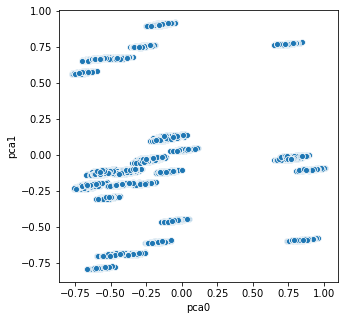

In [17]:
df_pca = pd.DataFrame(pca_result, columns=['pca0', 'pca1',])

plt.figure(figsize=(5, 5))
sns.scatterplot(x='pca0', y='pca1', data=df_pca)
# plt.subplot(4, 1, 2)
# sns.scatterplot(x='pca1', y='pca2', data=df_pca, hue='hue')
# plt.subplot(4, 1, 3)
# sns.scatterplot(x='pca0', y='pca2', data=df_pca, hue='hue')

<AxesSubplot:>

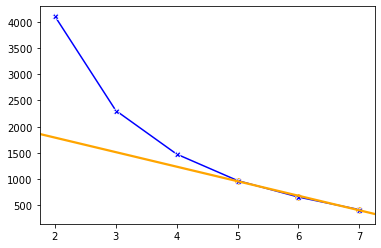

In [18]:
from sklearn.cluster import KMeans

### Elbow method 

distortions = []
inertias = []

_X = df_pca[['pca1', 'pca0']]

for k in range(2,8):
    inertias.append(KMeans(n_clusters=k).fit(_X).inertia_)

sns.lineplot(range(2, 8), inertias, marker='X', color='blue')
sns.regplot(list(range(5, 8)), inertias[3:], ci=None, color='orange')

# OPtimal n_compnents = 5

<AxesSubplot:xlabel='pca0', ylabel='pca1'>

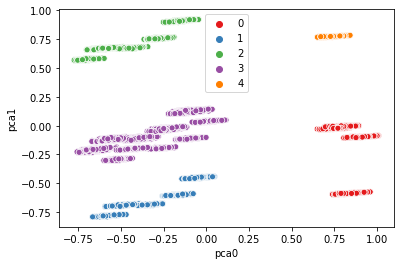

In [19]:
n_clusters = 5
km = KMeans(n_clusters=n_clusters, random_state=random_state)
y_km = km.fit_predict(df_pca[['pca1', 'pca0']])

df_pca['cluster'] = y_km

sns.scatterplot(x='pca0', y='pca1', data=df_pca, hue=y_km, palette=sns.color_palette("Set1", n_colors=n_clusters))

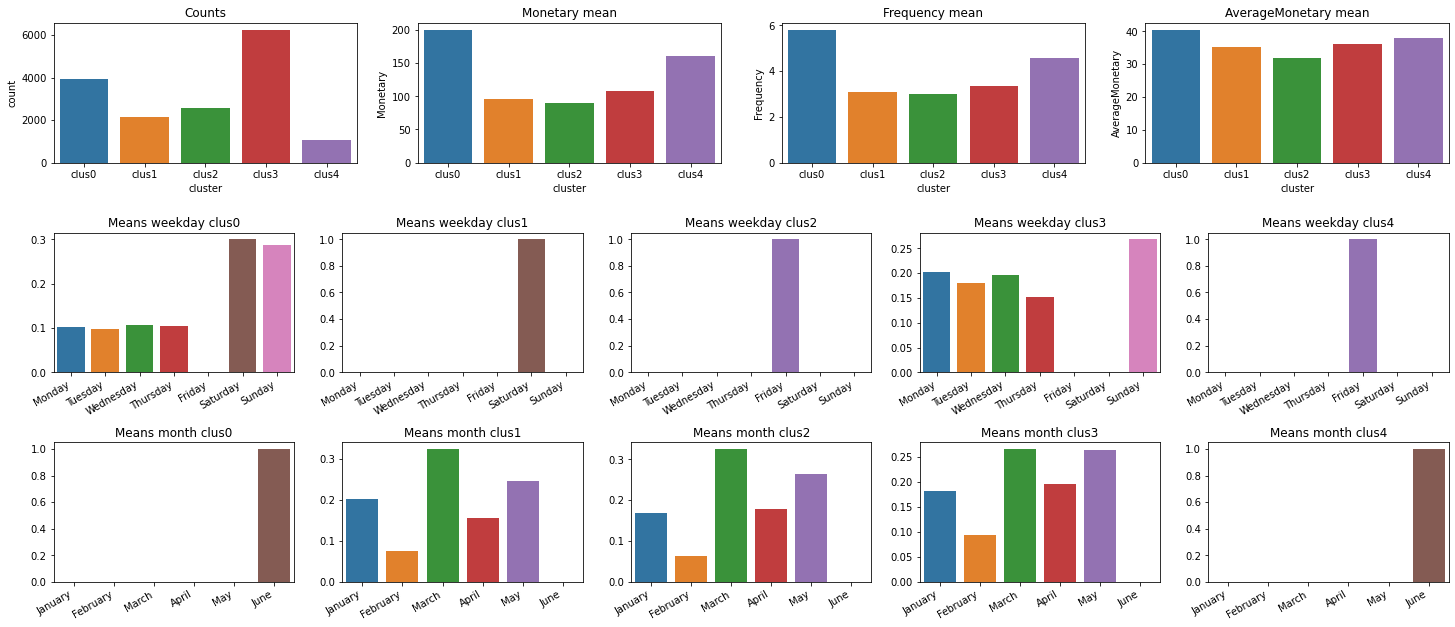

In [20]:
df_scaled['cluster'] = y_km
df_scaled['cluster'] = df_scaled['cluster'].apply(lambda x: f"clus{x}")

df_scaled['Monetary'] = segment['Monetary']
df_scaled['Frequency'] = segment['Frequency']
df_scaled['AverageMonetary'] = segment['AverageMonetary']
pairplot_features = np.concatenate([['cluster', 'Monetary', 'Frequency', 'AverageMonetary'], numeric_features, cats])


clusters = df_scaled['cluster'].unique()

data_counts = df_scaled['cluster'].value_counts().sort_index().rename('count')
data_means = df_scaled[pairplot_features].groupby('cluster').mean()
data = data_means.join(data_counts).reset_index()


plt.figure(figsize=(25, 18))
plt.subplots_adjust(hspace=0.5, wspace=0.2)


plt.subplot(5,4,1)
sns.barplot(x='cluster', y='count', data=data).set_title('Counts')
plt.subplot(5,4,2)
sns.barplot(x='cluster', y='Monetary', data=data).set_title('Monetary mean')
plt.subplot(5,4,3)
sns.barplot(x='cluster', y='Frequency', data=data).set_title('Frequency mean')
plt.subplot(5,4,4)
sns.barplot(x='cluster', y='AverageMonetary', data=data).set_title('AverageMonetary mean')

for index, cluster in enumerate(data['cluster']):
    plt.subplot(5,n_clusters,n_clusters+1+index)
    ax = sns.barplot(data=data[data['cluster'] == cluster][[f"weekday_{i}" for i in WEEKDAYS]])
    ax.set_title(f'Means weekday {cluster}')
    ax.set_xticklabels(
        WEEKDAYS.values(), 
        rotation=30, 
        horizontalalignment='right',
    )

    plt.subplot(5,n_clusters,2*n_clusters+1+index)
    ax = sns.barplot(data=data[data['cluster'] == cluster][[f"month_{i+1}" for i in range(6)]])
    ax.set_title(f'Means month {cluster}')
    ax.set_xticklabels(
        list(MONTHS.values())[:6],
        rotation=30, 
        horizontalalignment='right',
    )

# Интерпретация
#### Получены 4 кластера:
0. (clus0) Кластер пользователей, <b><i>совершивших</i></b> за последний месяц хотя бы один платеж и совершавших последний платеж <b><i>В пятницу</i></b>;
1. (clus1) Кластер пользователей, <b><i>НЕ совершивших</i></b> за последний месяц ни одного платежа и совершавших последний платеж <b><i>В субботу</i></b>;
2. (clus2) Кластер пользователей, <b><i>НЕ совершивших</i></b> за последний месяц ни одного платежа и совершавших последний платеж <b><i>В пятницу</i></b>;
3. (clus3) Кластер пользователей, <b><i>НЕ совершивших</i></b> за последний месяц ни одного платежа и совершавших последний платеж <b><i>НЕ в пятницу И НЕ в субботу</i></b>;
4. (clus4) Кластер пользователей, <b><i>совершивших</i></b> за последний месяц хотя бы один платеж и совершавших последний платеж <b><i>НЕ в пятницу</i></b>;

### Так как различия между кластерами 1, 2 и 3 "ушедших" пользователей практически одинаковы по "Monetary" и "Frequency", то имеет смысл объединить их в одну группу.
### Так же видно, что количество платежей в пятницу приблизительно равно количеству платежей активных пользователей в выходные дни, поэтому можно объединить их тоже.

,cluster,Monetary,Frequency,AverageMonetary,day,MonetaryLog,FrequencyLog,AverageMonetaryLog,weekday_0,weekday_1,...,weekday_4,weekday_5,weekday_6,month_1,month_2,month_3,month_4,month_5,month_6,count
0,clus0,213.482301,6.171499,41.264087,0.963562,0.589757,0.239923,0.545059,0.247995,0.235657,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1621
1,clus123,101.657485,3.215652,35.019159,0.497178,0.482550,0.131489,0.499603,0.115707,0.102770,...,0.232781,0.197431,0.152970,0.181942,0.083364,0.290725,0.183673,0.260295,0.0,10976
2,clus4,181.518910,5.263591,39.339319,0.971379,0.564357,0.211948,0.535375,0.000000,0.000000,...,0.318542,0.347634,0.333823,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,3403


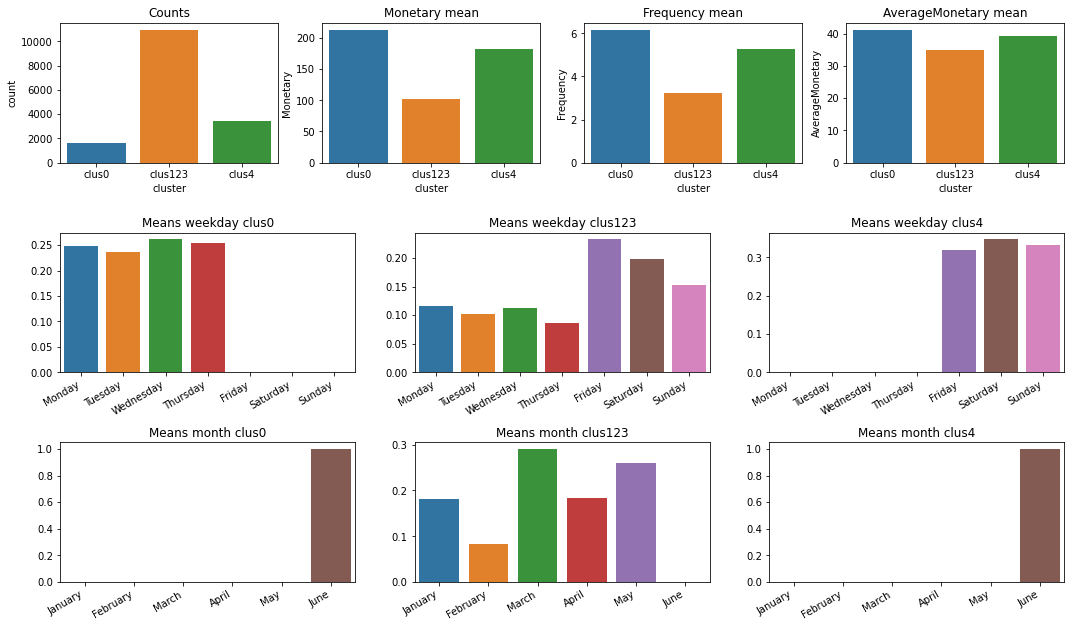

In [21]:
df_scaled['cluster'] = df_scaled['cluster'].apply(lambda x: "clus123" if x in ("clus1", "clus2", "clus3",) else x )
df_scaled['cluster'] = df_scaled[['cluster', 'weekday_5', 'weekday_6']].apply(lambda x: "clus4" if (x['weekday_5'] == 1 or x['weekday_6'] == 1) and x['cluster'] == "clus0" else x['cluster'], axis=1)
n_clusters = 3

clusters = df_scaled['cluster'].unique()

data_counts = df_scaled['cluster'].value_counts().sort_index().rename('count')
data_means = df_scaled[pairplot_features].groupby('cluster').mean()
data = data_means.join(data_counts).reset_index()
display(data)

plt.figure(figsize=(18, 18))
plt.subplots_adjust(hspace=0.5, wspace=0.2)

plt.subplot(5,4,1)
sns.barplot(x='cluster', y='count', data=data).set_title('Counts')
plt.subplot(5,4,2)
sns.barplot(x='cluster', y='Monetary', data=data).set_title('Monetary mean')
plt.subplot(5,4,3)
sns.barplot(x='cluster', y='Frequency', data=data).set_title('Frequency mean')
plt.subplot(5,4,4)
sns.barplot(x='cluster', y='AverageMonetary', data=data).set_title('AverageMonetary mean')

for index, cluster in enumerate(data['cluster']):
    plt.subplot(5,n_clusters,n_clusters+1+index)
    ax = sns.barplot(data=data[data['cluster'] == cluster][[f"weekday_{i}" for i in WEEKDAYS]])
    ax.set_title(f'Means weekday {cluster}')
    ax.set_xticklabels(
        WEEKDAYS.values(), 
        rotation=30, 
        horizontalalignment='right',
    )

    plt.subplot(5,n_clusters,2*n_clusters+1+index)
    ax = sns.barplot(data=data[data['cluster'] == cluster][[f"month_{i+1}" for i in range(6)]])
    ax.set_title(f'Means month {cluster}')
    ax.set_xticklabels(
        list(MONTHS.values())[:6],
        rotation=30, 
        horizontalalignment='right',
    )

# Интерпретация (продолжение)
#### Выделенные 3 группы:
1. (clus0) Кластер пользователей, <b><i>совершивших</i></b> за последний месяц хотя бы один платеж и совершавших последний платеж <b><i>В начале недели</i></b>;
2. (clus123) Кластер пользователей, <b><i>НЕ совершивших</i></b> за последний месяц ни одного платежа;
3. (clus4) Кластер пользователей, <b><i>совершивших</i></b> за последний месяц хотя бы один платеж и совершавших последний платеж <b><i>В конце недели</i></b>;

# Закономерности, которые можно выявить:
1. Группа активных пользователей clus4 по размеру в два раза больше группы активных пользователей clus0.
2. Средняя частота и общая сумма платежей clus4 на ~10% ниже группы clus0.
3. Основной оборот денежных средств (оборот ДС = count * mean monetary) был произведен группой пользователей, не совершивших ни одного платежа за последний месяц.
4. Распределение количества платежей внитри групп clus0 и clus4 равномерно по соответствующим дням недели.